In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments
from model.config.params import build_params
from model.kpis.utility import find_geo_zone_numbers
import numpy as np
from cadCAD.engine import ExecutionMode

df, simulation_kpis = run_experiments(["BaseEvent"], context = ExecutionMode().local_mode)

/Users/seanmcowen/opt/anaconda3/envs/BlockScience/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.0
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 365, 74, 1, 27)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 74, 1, 27)


Initializing configurations: 100%|████████████████| 1/1 [00:00<00:00, 82.45it/s]


Execution Method: single_proc_exec
Execution Mode: single_threaded
2023-12-21 10:49:31.406883


Flattening results:   0%|                     | 1/4016 [00:00<00:27, 144.64it/s]

Total execution time: 6.31s



## Basic Line Graphs

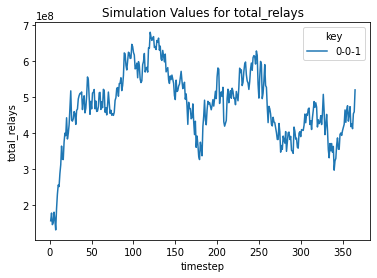

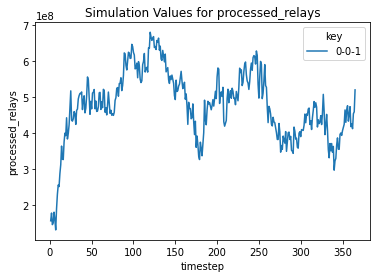

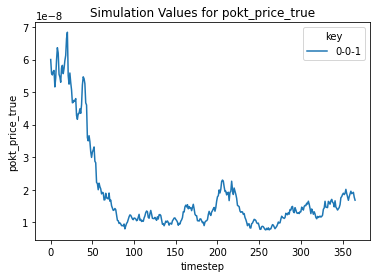

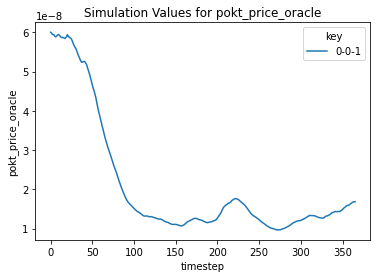

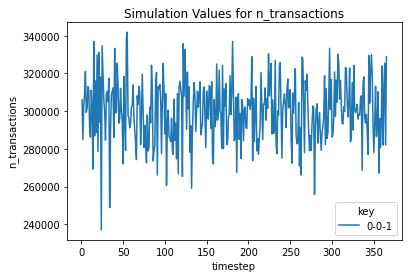

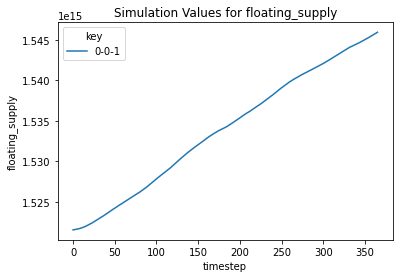

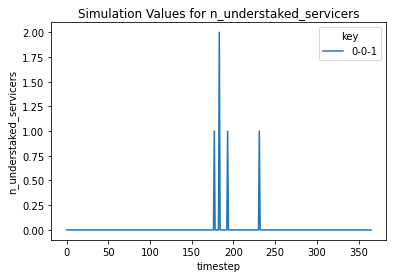

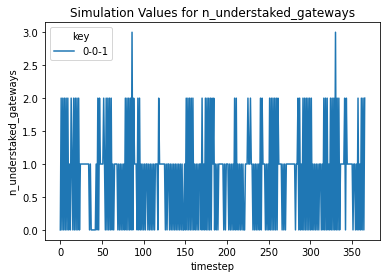

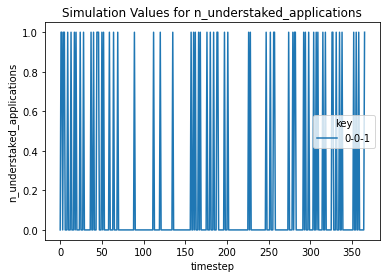

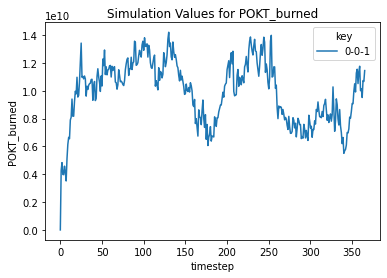

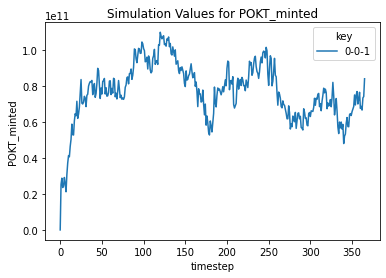

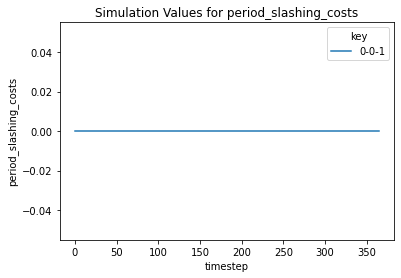

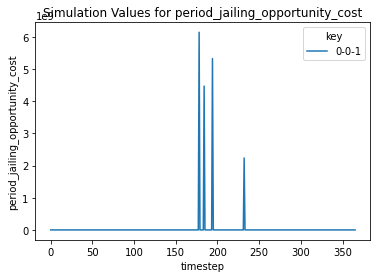

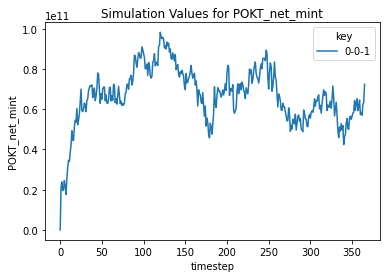

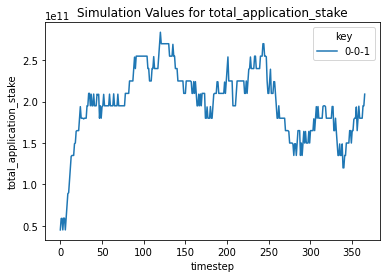

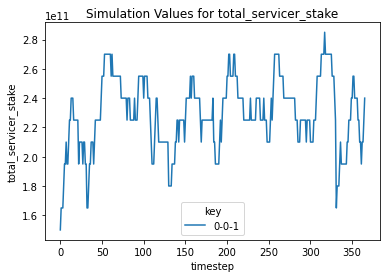

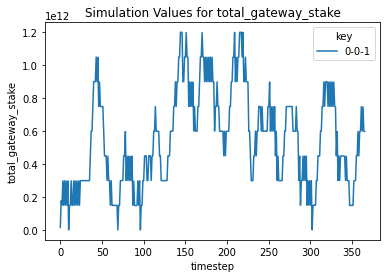

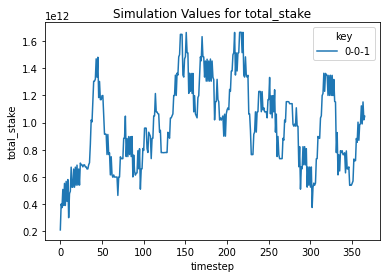

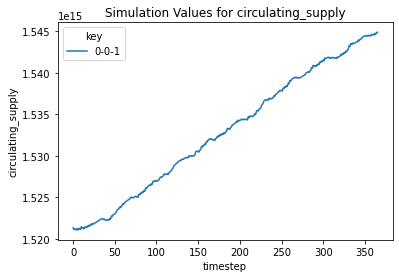

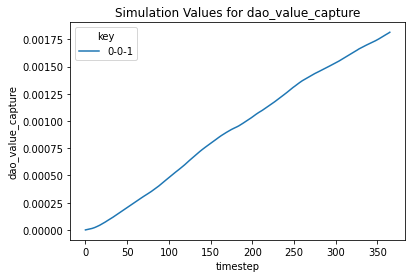

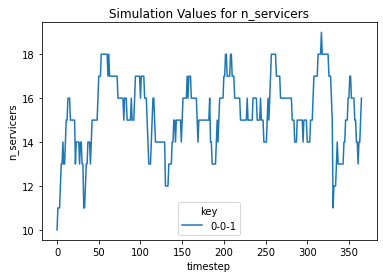

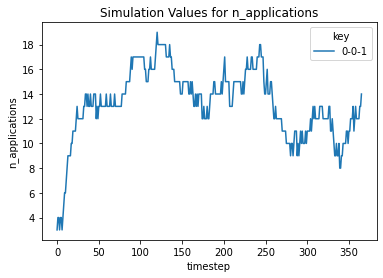

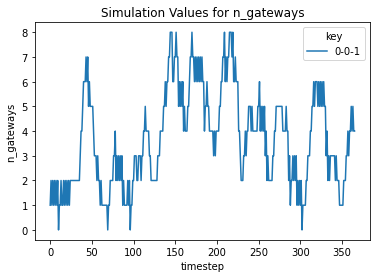

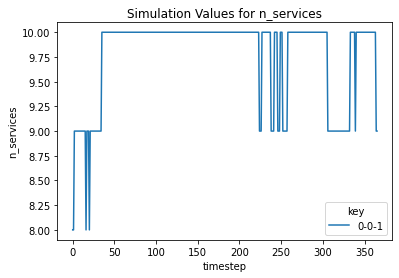

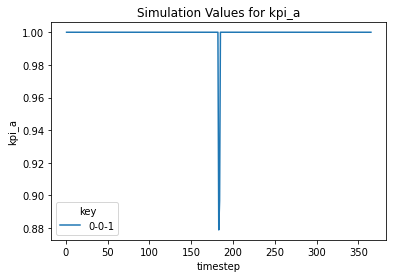

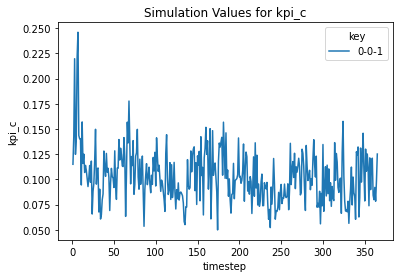

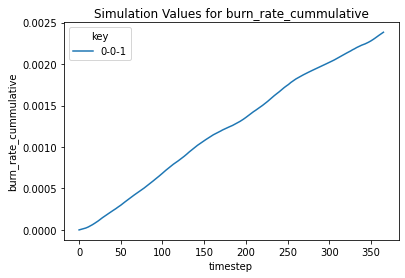

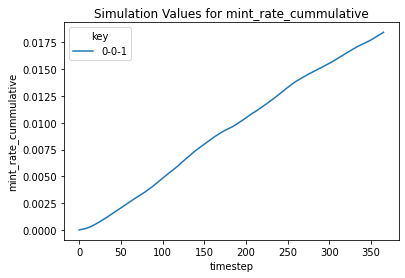

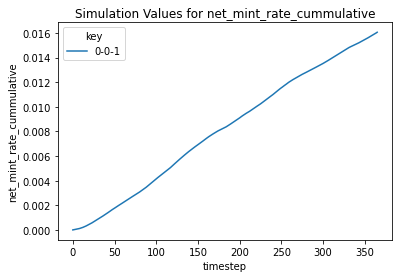

In [2]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a', 'kpi_c', 'burn_rate_cummulative',
       'mint_rate_cummulative', 'net_mint_rate_cummulative']:
    # Grab the pivot table
    table = df.pivot(index="timestep", columns="key", values=col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()

## ETC

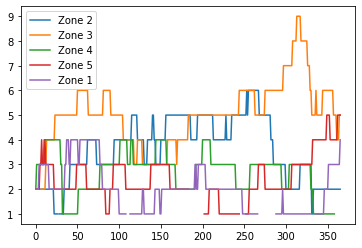

In [3]:
geo_zone_numbers = find_geo_zone_numbers(df)
geo_zone_numbers.plot(kind='line')
plt.show()